<a href="https://colab.research.google.com/github/BrendaLoznik/waterpumps/blob/main/3.%20Modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Housekeeping

### 1.1 Load libraries

In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

#machine learning
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from catboost import CatBoostClassifier
import shap

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

### 1.2 Custom functions

In [60]:
def confusion_matrix_plotter (y_test,y_pred):
  fig, ax = plt.subplots(figsize=(8,5)) 
  data = confusion_matrix(y_test, y_pred)
  df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
  ax = sns.heatmap(df_cm, cmap='Blues', fmt='g' ,annot=True,annot_kws={"size": 14})
  ax.set_xlabel("Predicted")
  ax.set_ylabel ("Actual")
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
  ax.set_yticklabels(ax.get_xticklabels(), rotation=0)

In [61]:
def feature_importances (model, title):
  features= X_train.columns
  importances = np.round(model.feature_importances_,3) 
  indices = np.argsort(importances)
  num_features = len(features)
  fig, ax = plt.subplots(figsize=(10,10)) 
  plt.barh(range(num_features), importances[indices[-num_features:]],  align='center', color =  '#66c2a5')
  plt.yticks(range(num_features), [features[i] for i in indices[-num_features:]])
  plt.xlabel('Relative Importance')
  plt.title('Feature Importance'+ title)
plt.show()

### 1.3 Load data

In [62]:
train_labels = pd.read_csv('../data/train/labels.csv')
train_values = pd.read_csv('../data/train/features.csv', parse_dates = ['date_recorded' ],  na_values = [0, '0'])
test_values = pd.read_csv('../data/test/test.csv', parse_dates = ['date_recorded' ] , na_values = [0, '0'])
final_df = pd.read_csv('../../final1_df.csv')
final_df = final_df.drop('Unnamed: 0', axis=1)

# 2 Modelling

In [63]:
#define train and test 
train_set = final_df [final_df ["id"].isin(train_values["id"])]
test_set =  final_df  [final_df  ["id"].isin(test_values["id"])]

In [64]:
#define X and y for training the model
X= train_set.drop(['id', 'status_group'], axis=1)
y = train_set['status_group']
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.2, random_state=42 , stratify=y)

### 2.1 Model overview

In [9]:
#define the models
models=[LogisticRegression(max_iter = 1000000,  random_state=42),
        KNeighborsClassifier(),
        DecisionTreeClassifier( random_state=42),
       RandomForestClassifier( random_state=42),
       XGBClassifier( random_state=42),
        BaggingClassifier( random_state=42), 
        AdaBoostClassifier( random_state=42),
        GradientBoostingClassifier( random_state=42),
       CatBoostClassifier( random_state=42)]

#create a list of model names
names =['Logistic Regression', 'KNN Classifier', 'Decision Tree Classifier', 'Random Forest Classifier',  'XGB Classifier', 'Bagging Classifier', 'AdaBoost Classifier', 'Gradient Boosting Classifier', 'Catboost Classifier']

#create empty lists for the accuracy and standard deviation
accuracy=[]
std = []

#peform 10-fold cross validaton on each model and append the results to the list
for model in models:
  cv = KFold(n_splits=10, shuffle = True,  random_state=1)
  n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
  mean_score = np.mean(n_scores)
  std_score = np.std(n_scores)
  accuracy.append(mean_score)
  std.append(std_score)

#create a dataframe of the model performances
d = {'Model':names,'Accuracy':accuracy, 'Std':std}   
score_df = pd.DataFrame(d)
score_df

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2], got ['functional' 'functional needs repair' 'non functional']

### 2.2 Random forest

In [10]:
#(running the script on Google Colab takes too long, so I will just share the results of the best_model
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.2, random_state=42 , stratify=y)


param_grid = { 'n_estimators': [ 150, 175,  200, 225],
             'max_features':['log2', ],
             'max_depth' : [30 , 40, 50, 60, 70],      
             'min_samples_split':[6, 7, 8, 9, 10]}



#Create a based model
rf =     RandomForestClassifier( random_state=42, warm_start = True)

grid_search_rf = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5,  verbose = 2,  scoring = 'accuracy')

#fitmodel
grid_search_rf .fit(X_train, y_train)

#print best parameters 
print('Best Score:', grid_search_rf .best_score_)
print('Parameters:', grid_search_rf .best_params_)
print('Best Model:', grid_search_rf .best_estimator_)



Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END max_depth=30, max_features=log2, min_samples_split=6, n_estimators=150; total time=   5.2s
[CV] END max_depth=30, max_features=log2, min_samples_split=6, n_estimators=150; total time=   5.3s
[CV] END max_depth=30, max_features=log2, min_samples_split=6, n_estimators=150; total time=   5.2s
[CV] END max_depth=30, max_features=log2, min_samples_split=6, n_estimators=150; total time=   5.3s
[CV] END max_depth=30, max_features=log2, min_samples_split=6, n_estimators=150; total time=   5.3s
[CV] END max_depth=30, max_features=log2, min_samples_split=6, n_estimators=175; total time=   6.2s
[CV] END max_depth=30, max_features=log2, min_samples_split=6, n_estimators=175; total time=   6.1s
[CV] END max_depth=30, max_features=log2, min_samples_split=6, n_estimators=175; total time=   6.1s
[CV] END max_depth=30, max_features=log2, min_samples_split=6, n_estimators=175; total time=   6.1s
[CV] END max_depth=30, max_features=l

In [17]:
#score model
best_model = RandomForestClassifier(max_depth=30, max_features='log2', min_samples_split=7, n_estimators=225, random_state=42, warm_start=True)

#fit and predict
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_pred_train = best_model.predict(X_train)

#print best model scores on test data
print("Accuracy score train: {}".format(accuracy_score(y_train, y_pred_train)))
print("Accuracy score test: {}".format(accuracy_score(y_test, y_pred)))
print()

#print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

confusion_matrix_plotter(y_test, y_pred)

feature_importances(best_model, " Random forest classifier")

### 2.3 Xgboost

In [15]:
# Create training and test sets: test size 0.2
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)


param_grid = { 'n_estimators': [ 200, ],
              'colsample_bytree' :[  0.3, ],
              'eta': [0.2,],
             'max_depth': [12]}


#Create a based model
xgb =     XGBClassifier( random_state=42)

grid_search_xgb = GridSearchCV(estimator = xgb, param_grid = param_grid, cv = 5,  verbose = 2,  scoring = 'accuracy')

#fitmodel
grid_search_xgb .fit(X_train, y_train,  eval_metric = 'mlogloss',)

#print best parameters 
print('Best Score:', grid_search_xgb .best_score_)
print('Parameters:', grid_search_xgb .best_params_)
print('Best Model:', grid_search_xgb .best_estimator_)


In [18]:
xgb = XGBClassifier( random_state=42, n_estimators = 200, colsample_bytree = 0.3, eta = 0.2, max_depth = 12 )

Accuracy score train: 0.9213367284665082
Accuracy score test: 0.8115319865319865

                         precision    recall  f1-score   support

             functional       0.80      0.91      0.85      6452
functional needs repair       0.61      0.27      0.38       863
         non functional       0.85      0.78      0.81      4565

               accuracy                           0.81     11880
              macro avg       0.76      0.65      0.68     11880
           weighted avg       0.81      0.81      0.80     11880



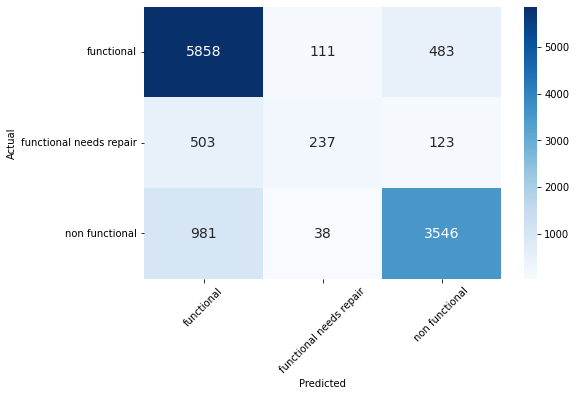

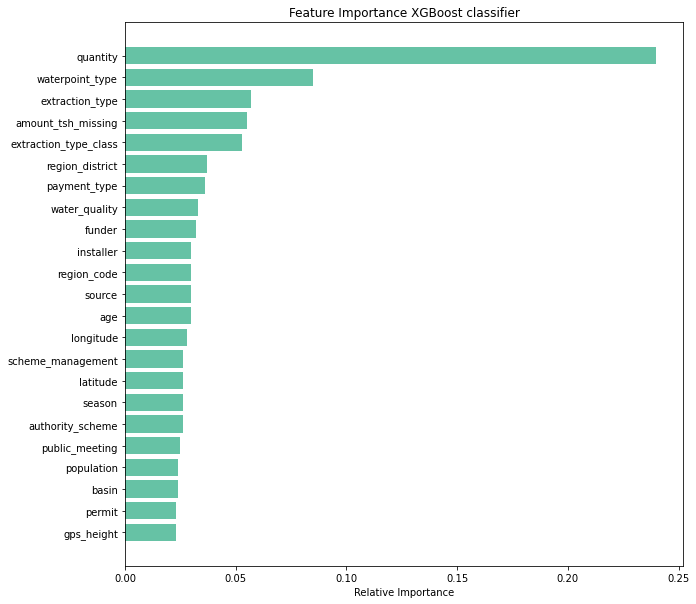

In [ ]:
#score model
best_model = XGBClassifier( random_state=42, n_estimators = 200, colsample_bytree = 0.3, eta = 0.2, max_depth = 12 )
best_model .fit(X_train, y_train,  eval_metric = 'mlogloss',)
y_pred = best_model.predict(X_test)
y_pred_train = best_model.predict(X_train)


#print best model scores on test data
print("Accuracy score train: {}".format(accuracy_score(y_train, y_pred_train)))
print("Accuracy score test: {}".format(accuracy_score(y_test, y_pred)))
print()

#print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

confusion_matrix_plotter(y_test, y_pred)

feature_importances(best_model, " XGBoost classifier")

### 2.4 Catboost

In [16]:
# Create training and test sets: test size 0.2
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.2, random_state=42 , stratify=y)


param_grid = { 'max_depth': [ 7,8,9],
              'iterations': [1000, 750],
              'rsm' :[0.3, 0.2]}

#Create a based model
cat  =     CatBoostClassifier( random_state=42)

grid_search_cat = GridSearchCV(estimator = cat, param_grid = param_grid, cv = 5,  verbose = 2,  scoring = 'accuracy')

#fitmodel
grid_search_cat .fit(X_train, y_train)

#print best parameters 
print('Best Score:', grid_search_cat .best_score_)
print('Parameters:', grid_search_cat .best_params_)
print('Best Model:', grid_search_cat .best_estimator_)




In [19]:
cat = CatBoostClassifier( random_state=42, rsm = 0.2, max_depth =9, iterations = 1000)

In [ ]:
#score model
best_model = CatBoostClassifier( random_state=42, rsm = 0.2, max_depth =9, iterations = 1000)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_pred_train = best_model.predict(X_train)


Accuracy score train: 0.8718196931753615
Accuracy score test: 0.8038720538720538

                         precision    recall  f1-score   support

             functional       0.79      0.90      0.85      6452
functional needs repair       0.60      0.28      0.39       863
         non functional       0.84      0.76      0.80      4565

               accuracy                           0.80     11880
              macro avg       0.75      0.65      0.68     11880
           weighted avg       0.80      0.80      0.79     11880



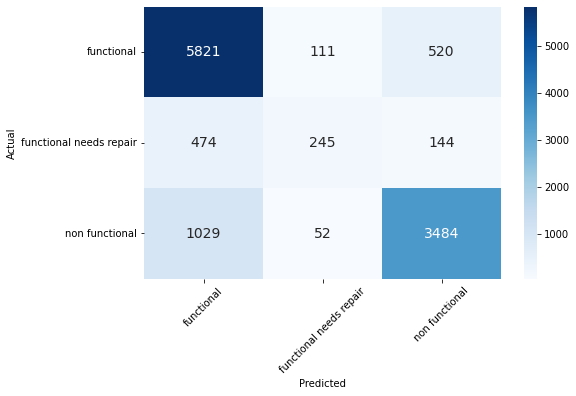

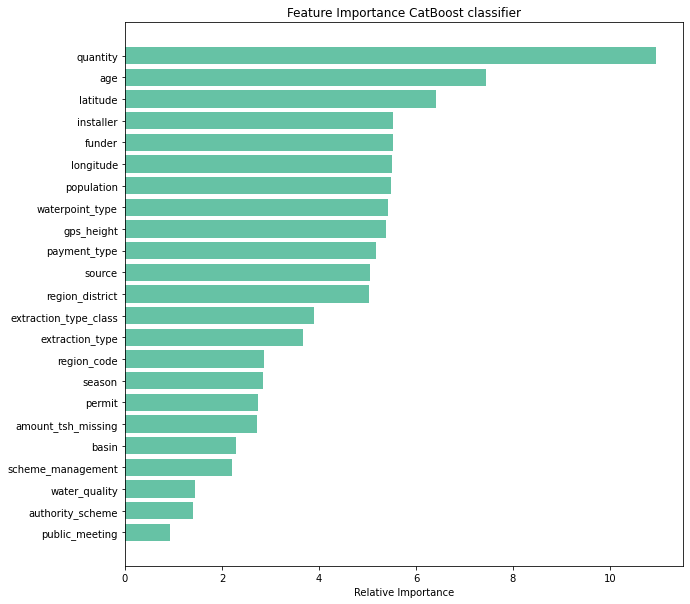

In [ ]:


#print best model scores on test data
print("Accuracy score train: {}".format(accuracy_score(y_train, y_pred_train)))
print("Accuracy score test: {}".format(accuracy_score(y_test, y_pred)))
print()

#print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

confusion_matrix_plotter(y_test, y_pred)

feature_importances(best_model, " CatBoost classifier")

### 2.5 Bagging

In [ ]:
# Create training and test sets: test size 0.2
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.2, random_state=42)


param_grid = { 'n_estimators': [100, 200, 300, 400, 500, 700, 800, 900, 1000],
              'max_features': [0.2, 0.25, 0.3, 0.35, 0.4]}

    

#Create a based model
bag  =      BaggingClassifier( random_state=42, )

grid_search_bag = RandomizedSearchCV(estimator = bag, param_distributions = param_grid, cv =5, n_iter = 45,
                               verbose = 2, scoring = 'accuracy')

#fitmodel
grid_search_bag.fit(X_train, y_train )

#print best parameters 
print('Best Score:', grid_search_bag.best_score_)
print('Parameters:', grid_search_bag.best_params_)
print('Best Model:',grid_search_bag .best_estimator_)

In [20]:
bag = BaggingClassifier( random_state=42, n_estimators = 1000, max_features = 0.4 )

Accuracy score train: 0.9642879690229171
Accuracy score test: 0.8079124579124579

                         precision    recall  f1-score   support

             functional       0.80      0.91      0.85      6452
functional needs repair       0.61      0.26      0.37       863
         non functional       0.85      0.77      0.81      4565

               accuracy                           0.81     11880
              macro avg       0.75      0.65      0.67     11880
           weighted avg       0.80      0.81      0.80     11880



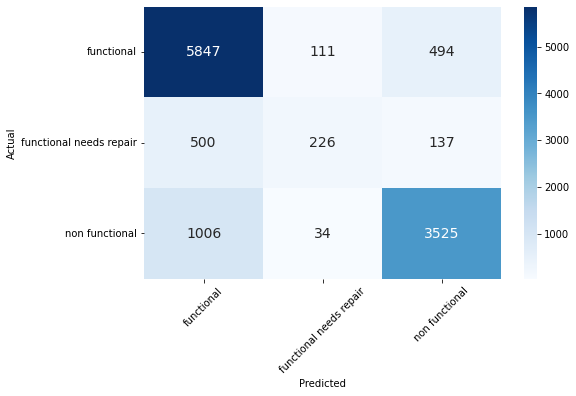

In [ ]:
#get scores
best_model = BaggingClassifier( random_state=42, n_estimators = 1000, max_features = 0.4 )
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_pred_train = best_model.predict(X_train)


#print best model scores on test data
print("Accuracy score train: {}".format(accuracy_score(y_train, y_pred_train)))
print("Accuracy score test: {}".format(accuracy_score(y_test, y_pred)))
print()

#print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

confusion_matrix_plotter(y_test, y_pred)


### 2.6 Mixed vote

In [49]:
rf = RandomForestClassifier(max_depth=30, max_features='log2', min_samples_split=7, n_estimators=225, random_state=42, warm_start=True)
xgb = XGBClassifier(max_depth =12, n_estimators= 200, colsample_bytree = 0.3, eta = 0.2, random_state = 42) 
cat = CatBoostClassifier(max_depth = 9, rsm = 0.2, iterations = 1000, random_state = 42)
bag = BaggingClassifier(max_features=0.4, n_estimators=1000, random_state=42) 


Learning rate set to 0.096348
0:	learn: 1.0292113	total: 31.2ms	remaining: 31.2s
1:	learn: 0.9779545	total: 67.5ms	remaining: 33.7s
2:	learn: 0.9340201	total: 98.1ms	remaining: 32.6s
3:	learn: 0.8959598	total: 131ms	remaining: 32.7s
4:	learn: 0.8630482	total: 170ms	remaining: 33.8s
5:	learn: 0.8346864	total: 206ms	remaining: 34.2s
6:	learn: 0.8097067	total: 240ms	remaining: 34s
7:	learn: 0.7885801	total: 273ms	remaining: 33.9s
8:	learn: 0.7713513	total: 310ms	remaining: 34.2s
9:	learn: 0.7547844	total: 341ms	remaining: 33.7s
10:	learn: 0.7403570	total: 371ms	remaining: 33.3s
11:	learn: 0.7280445	total: 408ms	remaining: 33.6s
12:	learn: 0.7174838	total: 438ms	remaining: 33.3s
13:	learn: 0.7078033	total: 465ms	remaining: 32.8s
14:	learn: 0.6996611	total: 499ms	remaining: 32.7s
15:	learn: 0.6919040	total: 524ms	remaining: 32.2s
16:	learn: 0.6853867	total: 554ms	remaining: 32s
17:	learn: 0.6793570	total: 577ms	remaining: 31.5s
18:	learn: 0.6731412	total: 606ms	remaining: 31.3s
19:	learn: 0

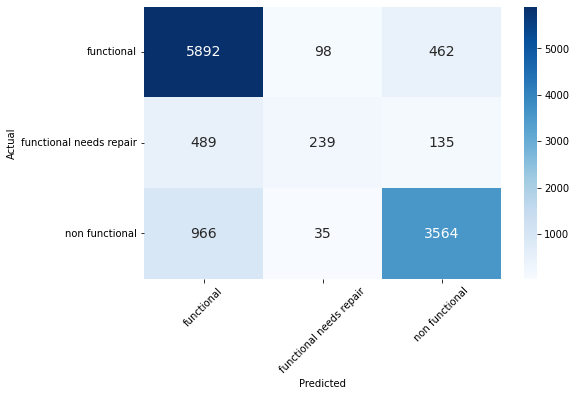

In [ ]:
# Create training and test sets: test size 0.2
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)


vc = VotingClassifier([('rf', rf), ('xgb', xgb),('cat', cat), ('bag', bag)], voting = 'soft')
                       

#fit and predict
vc.fit(X_train , y_train)
pred= vc .predict(X_test)
pred_train = vc .predict(X_train)


#print best model scores on test data
print("Accuracy score train: {}".format(accuracy_score(y_train ,pred_train)))
print("Accuracy score test: {}".format(accuracy_score(y_test, pred)))

#print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, pred))

#heatmap
fig, ax = plt.subplots(figsize=(8,5)) 
data = confusion_matrix(y_test, pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
ax = sns.heatmap(df_cm, cmap='Blues', fmt='g' ,annot=True,annot_kws={"size": 14})
ax.set_xlabel("Predicted")
ax.set_ylabel ("Actual")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_yticklabels(ax.get_xticklabels(), rotation=0)
plt.show()

### 2.7  Xgboost vote

In [ ]:
xgb1 = XGBClassifier(max_depth =12, n_estimators= 200, colsample_bytree = 0.3, eta = 0.2, random_state = 42)
xgb2 = XGBClassifier(max_depth =12, n_estimators= 200, colsample_bytree = 0.3, eta = 0.2, random_state = 2) 
xgb3 = XGBClassifier(max_depth =12, n_estimators= 200, colsample_bytree = 0.3, eta = 0.2, random_state = 142) 
xgb4 = XGBClassifier(max_depth =12, n_estimators= 200, colsample_bytree = 0.3, eta = 0.2, random_state = 33 )
xgb5 = XGBClassifier(max_depth =12, n_estimators= 200, colsample_bytree = 0.3, eta = 0.2, random_state = 678)

Accuracy score train: 0.9217155243165892
Accuracy score test: 0.8128787878787879
                         precision    recall  f1-score   support

             functional       0.80      0.91      0.85      6452
functional needs repair       0.62      0.28      0.39       863
         non functional       0.86      0.77      0.81      4565

               accuracy                           0.81     11880
              macro avg       0.76      0.66      0.68     11880
           weighted avg       0.81      0.81      0.80     11880



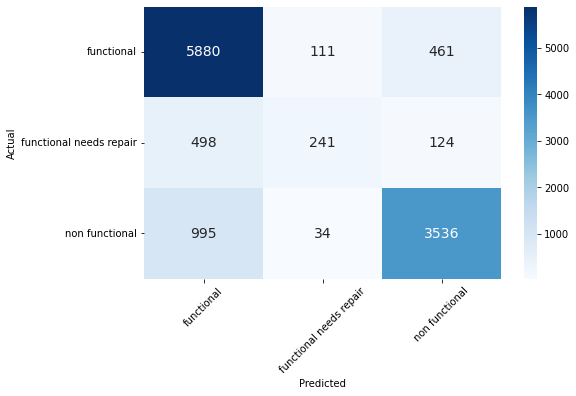

In [ ]:
# Create training and test sets: test size 0.2
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)


vc = VotingClassifier([('xgb1', xgb1), ('xgb2', xgb2), ('xgb3', xgb3), ('xgb4', xgb4), ('xgb5', xgb5)], voting = 'soft')
                       

#fit and predict
vc.fit(X_train , y_train)
pred= vc .predict(X_test)
pred_train = vc .predict(X_train)


#print best model scores on test data
print("Accuracy score train: {}".format(accuracy_score(y_train ,pred_train)))
print("Accuracy score test: {}".format(accuracy_score(y_test, pred)))

#print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, pred))

#heatmap
fig, ax = plt.subplots(figsize=(8,5)) 
data = confusion_matrix(y_test, pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
ax = sns.heatmap(df_cm, cmap='Blues', fmt='g' ,annot=True,annot_kws={"size": 14})
ax.set_xlabel("Predicted")
ax.set_ylabel ("Actual")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_yticklabels(ax.get_xticklabels(), rotation=0)
plt.show()

### 2.8 Stacking

Streaminguitvoer ingekort tot de laatste 5000 regels.
16:	learn: 0.6853677	total: 484ms	remaining: 28s
17:	learn: 0.6791858	total: 503ms	remaining: 27.4s
18:	learn: 0.6729272	total: 528ms	remaining: 27.3s
19:	learn: 0.6675945	total: 554ms	remaining: 27.1s
20:	learn: 0.6626043	total: 584ms	remaining: 27.2s
21:	learn: 0.6571873	total: 611ms	remaining: 27.2s
22:	learn: 0.6524886	total: 635ms	remaining: 27s
23:	learn: 0.6486921	total: 671ms	remaining: 27.3s
24:	learn: 0.6442582	total: 703ms	remaining: 27.4s
25:	learn: 0.6414799	total: 720ms	remaining: 27s
26:	learn: 0.6372114	total: 753ms	remaining: 27.1s
27:	learn: 0.6328607	total: 778ms	remaining: 27s
28:	learn: 0.6298907	total: 805ms	remaining: 26.9s
29:	learn: 0.6257803	total: 833ms	remaining: 26.9s
30:	learn: 0.6227750	total: 869ms	remaining: 27.2s
31:	learn: 0.6198419	total: 900ms	remaining: 27.2s
32:	learn: 0.6169707	total: 926ms	remaining: 27.1s
33:	learn: 0.6144363	total: 955ms	remaining: 27.1s
34:	learn: 0.6140794	total: 965ms	re

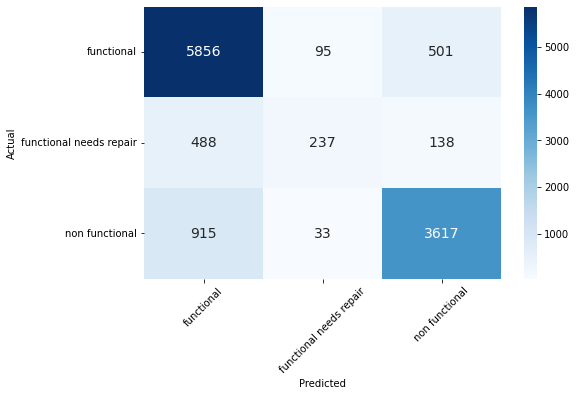

In [ ]:
# Create training and test sets: test size 0.2
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)


stack = StackingClassifier([('rf', rf), 
                              ('xgb', xgb),
                              ('cat', cat),
                           ('bag', bag)], final_estimator=LogisticRegression())
                       

#fit and predict
stack.fit(X_train , y_train)
pred= stack.predict(X_test)
pred_train = stack.predict(X_train)


#print best model scores on test data
print("Accuracy score train: {}".format(accuracy_score(y_train ,pred_train)))
print("Accuracy score test: {}".format(accuracy_score(y_test, pred)))


#print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, pred))

#heatmap
fig, ax = plt.subplots(figsize=(8,5)) 
data = confusion_matrix(y_test, pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
ax = sns.heatmap(df_cm, cmap='Blues', fmt='g' ,annot=True,annot_kws={"size": 14})
ax.set_xlabel("Predicted")
ax.set_ylabel ("Actual")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_yticklabels(ax.get_xticklabels(), rotation=0)
plt.show()

### 2.9 Weighted vote

In [20]:
import random

# Create training and test sets: test size 0.2
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

best_weights = [0, 0, 0, 0]
best_acc = 0.0

i = 0

while True:
    i+=1

    w = [round(random.uniform(0.3, 1.0), 3), round(random.uniform(0.3, 1.0), 3), round(random.uniform(0.3, 1.0), 3), round(random.uniform(0.3, 1.0), 3)]

    vc = VotingClassifier([('rf', rf), ('xgb', xgb),('cat', cat), ('bag', bag)], voting = 'soft', weights = w)         

    #fit and predict
    vc.fit(X_train , y_train)
    pred= vc .predict(X_test)
    pred_train = vc .predict(X_train)

    acc = accuracy_score(y_test, pred)

    #print best model scores on test data
    print("Accuracy score train: {}".format(accuracy_score(y_train ,pred_train)))
    print("Accuracy score test: {}".format(acc))
    print("Weights:", w)

    if acc > best_acc:
        best_acc = acc
        best_weights = w

    print("Best weights:", best_weights, "with result:", best_acc)

    # open the file in write mode
    with open('output.txt', 'a') as f:
        # print best model scores on test data to file
        f.write("\nIteration: {}\n".format(i))
        f.write("Accuracy score train: {}\n".format(accuracy_score(y_train, pred_train)))
        f.write("Accuracy score test: {}\n".format(acc))
        f.write("Weights: {}\n".format(w))
        f.write("Best weights: {} with result: {}\n".format(best_weights, best_acc))


# Best weights: [0.758, 0.637, 0.54, 0.611] with result: 0.8170875420875421 -> submission: 0.8219
# Best weights: [0.808, 0.878, 0.762, 0.647] with result: 0.8170875420875421

Learning rate set to 0.096348
0:	learn: 1.0292113	total: 10.4ms	remaining: 10.4s
1:	learn: 0.9779545	total: 20.5ms	remaining: 10.2s
2:	learn: 0.9340201	total: 30.6ms	remaining: 10.2s
3:	learn: 0.8959598	total: 39.8ms	remaining: 9.9s
4:	learn: 0.8630482	total: 49.6ms	remaining: 9.87s
5:	learn: 0.8346864	total: 59.1ms	remaining: 9.79s
6:	learn: 0.8097067	total: 68ms	remaining: 9.65s
7:	learn: 0.7885801	total: 77.2ms	remaining: 9.57s
8:	learn: 0.7713513	total: 88.6ms	remaining: 9.75s
9:	learn: 0.7547844	total: 96.7ms	remaining: 9.58s
10:	learn: 0.7403570	total: 106ms	remaining: 9.53s
11:	learn: 0.7280445	total: 116ms	remaining: 9.58s
12:	learn: 0.7174838	total: 125ms	remaining: 9.52s
13:	learn: 0.7078033	total: 134ms	remaining: 9.43s
14:	learn: 0.6996611	total: 143ms	remaining: 9.39s
15:	learn: 0.6919040	total: 151ms	remaining: 9.26s
16:	learn: 0.6853867	total: 159ms	remaining: 9.19s
17:	learn: 0.6793570	total: 165ms	remaining: 9.01s
18:	learn: 0.6731412	total: 173ms	remaining: 8.95s
19:	

KeyboardInterrupt: 

In [65]:
rf = RandomForestClassifier(max_depth=30, max_features='log2', min_samples_split=7, n_estimators=225, random_state=42, warm_start=True)
xgb = XGBClassifier(max_depth =12, n_estimators= 200, colsample_bytree = 0.3, eta = 0.2, random_state = 42) 
cat = CatBoostClassifier(max_depth = 9, rsm = 0.2, iterations = 1000, random_state = 42)
bag = BaggingClassifier(max_features=0.4, n_estimators=1000, random_state=42) 


Learning rate set to 0.096348
0:	learn: 1.0292113	total: 9.89ms	remaining: 9.88s
1:	learn: 0.9779545	total: 19.7ms	remaining: 9.82s
2:	learn: 0.9340201	total: 27.7ms	remaining: 9.2s
3:	learn: 0.8959598	total: 36.8ms	remaining: 9.16s
4:	learn: 0.8630482	total: 46.9ms	remaining: 9.34s
5:	learn: 0.8346864	total: 55.8ms	remaining: 9.24s
6:	learn: 0.8097067	total: 65.7ms	remaining: 9.33s
7:	learn: 0.7885801	total: 73.5ms	remaining: 9.11s
8:	learn: 0.7713513	total: 84.5ms	remaining: 9.31s
9:	learn: 0.7547844	total: 94.1ms	remaining: 9.32s
10:	learn: 0.7403570	total: 104ms	remaining: 9.38s
11:	learn: 0.7280445	total: 113ms	remaining: 9.32s
12:	learn: 0.7174838	total: 122ms	remaining: 9.23s
13:	learn: 0.7078033	total: 129ms	remaining: 9.1s
14:	learn: 0.6996611	total: 138ms	remaining: 9.09s
15:	learn: 0.6919040	total: 146ms	remaining: 8.96s
16:	learn: 0.6853867	total: 154ms	remaining: 8.9s
17:	learn: 0.6793570	total: 160ms	remaining: 8.75s
18:	learn: 0.6731412	total: 168ms	remaining: 8.69s
19:	

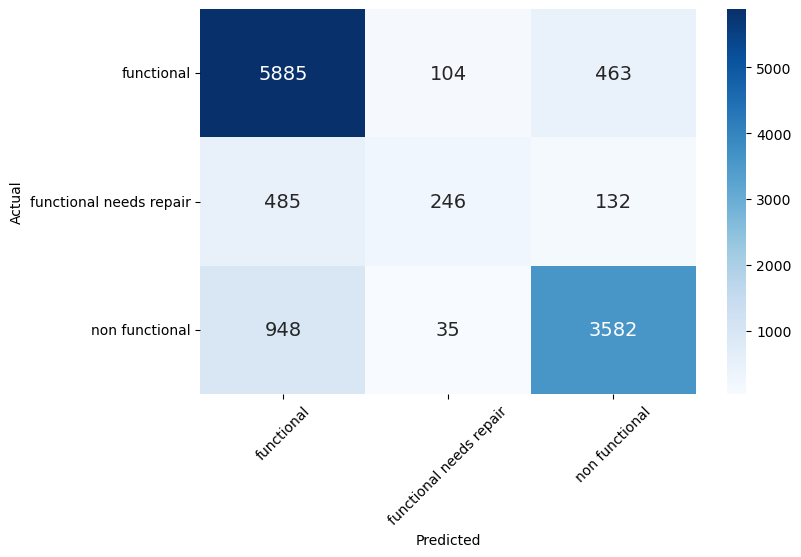

In [66]:
# Create training and test sets: test size 0.2
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)


vc = VotingClassifier([('rf', rf), ('xgb', xgb),('cat', cat), ('bag', bag)], voting = 'soft', weights = [0.861, 0.78, 0.706, 0.751])
                       

#fit and predict
vc.fit(X_train , y_train)
pred= vc .predict(X_test)
pred_train = vc .predict(X_train)


#print best model scores on test data
print("Accuracy score train: {}".format(accuracy_score(y_train ,pred_train)))
print("Accuracy score test: {}".format(accuracy_score(y_test, pred)))

#print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, pred))

#heatmap
fig, ax = plt.subplots(figsize=(8,5)) 
data = confusion_matrix(y_test, pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
ax = sns.heatmap(df_cm, cmap='Blues', fmt='g' ,annot=True,annot_kws={"size": 14})
ax.set_xlabel("Predicted")
ax.set_ylabel ("Actual")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_yticklabels(ax.get_xticklabels(), rotation=0)
plt.show()

In [39]:
#fit on foll training set
vc.fit(X , y)

#predict
submission = test_set.drop(['id', 'status_group'], axis=1)
submission['status_group'] = vc.predict(submission)

#bring the id column back
submission['id'] = test_set['id']

#create df for submission and save
best_submission = submission[['id', 'status_group']]
best_submission.head()

Learning rate set to 0.097451
0:	learn: 1.0278540	total: 11.3ms	remaining: 11.3s
1:	learn: 0.9750143	total: 22.2ms	remaining: 11.1s
2:	learn: 0.9306670	total: 31.1ms	remaining: 10.3s
3:	learn: 0.8930919	total: 40.9ms	remaining: 10.2s
4:	learn: 0.8594394	total: 51ms	remaining: 10.2s
5:	learn: 0.8310163	total: 61.5ms	remaining: 10.2s
6:	learn: 0.8050507	total: 70.7ms	remaining: 10s
7:	learn: 0.7839944	total: 80.4ms	remaining: 9.97s
8:	learn: 0.7658719	total: 90.3ms	remaining: 9.94s
9:	learn: 0.7496496	total: 103ms	remaining: 10.2s
10:	learn: 0.7351999	total: 119ms	remaining: 10.7s
11:	learn: 0.7233117	total: 129ms	remaining: 10.6s
12:	learn: 0.7130750	total: 140ms	remaining: 10.6s
13:	learn: 0.7035386	total: 148ms	remaining: 10.4s
14:	learn: 0.6956033	total: 159ms	remaining: 10.5s
15:	learn: 0.6878254	total: 168ms	remaining: 10.3s
16:	learn: 0.6814857	total: 176ms	remaining: 10.2s
17:	learn: 0.6756413	total: 183ms	remaining: 9.98s
18:	learn: 0.6690023	total: 191ms	remaining: 9.88s
19:	le

,id,status_group
59399,50785,non functional
59400,51630,functional
59401,17168,functional
59402,45559,non functional
59403,49871,functional


In [40]:
best_submission.head()

,id,status_group
59399,50785,non functional
59400,51630,functional
59401,17168,functional
59402,45559,non functional
59403,49871,functional


In [41]:
best_submission.to_csv('best_submission.csv', index=False)

# 3 Result overview

In [ ]:
models = ['Random Forest Classifier', 'XgBoost Classifier', 'CatBoost Classifier', 'Bagging Classifier', 'Mixed Voting Classifier','XGBoost Voting Classifier', 'Stacking Classifier', 'Weighted Voting Classifier']
training_accuracy = [0.9219, 0.9501, 0.8721, 0.8741, 0.9358, 0.9509, 0.9384, 0.9356]
testing_accuracy = [0.8131, 0.8110, 0.8034, 0.8667, 0.8160, 0.8131, 0.8160, 0.8150]
competition_accuracy = [0.8133, 0.8173, 0.8125, 0.8150, 0.8234,  0.8205, 0.8226, 0.8235  ]

d = {'Model':models,'Train accuracy':training_accuracy, 'Test accuracy':testing_accuracy, 'Competition accuracy': competition_accuracy}   
score_df = pd.DataFrame(d)
score_df 

,Model,Train accuracy,Test accuracy,Competition accuracy
0,Random Forest Classifier,0.9219,0.8131,0.8133
1,XgBoost Classifier,0.9501,0.8110,0.8173
2,CatBoost Classifier,0.8721,0.8034,0.8125
3,Bagging Classifier,0.8741,0.8667,0.8150
4,Mixed Voting Classifier,0.9358,0.8160,0.8234
5,XGBoost Voting Classifier,0.9509,0.8131,0.8205
6,Stacking Classifier,0.9384,0.8160,0.8226
7,Weighted Voting Classifier,0.9356,0.8150,0.8235


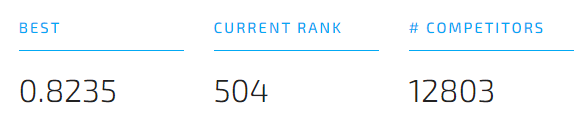

Disclaimer: I did all my modelling in Databricks and transfered by code to Google Colab. The results may therefore vary slightly.

# 4 SHAP

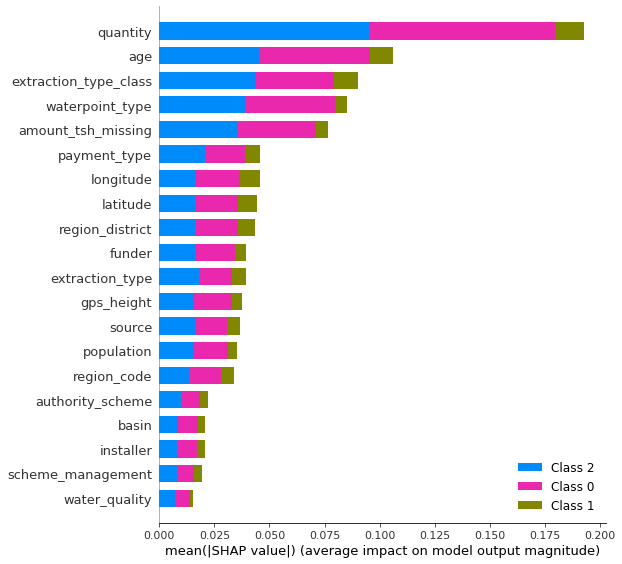

In [ ]:
df=train_set.copy()

#calcualte how many samples of each status group I need
required_samples = len(df)*0.4  #40%
functional_samples = round(required_samples* 0.543081)
non_functional_samples = round(required_samples * 0.384242)
repair_samples = round(required_samples * 0.072677)

#create sepperate df for each status group
functional = df[df['status_group']=='functional']
non_functional = df[df['status_group']=='non functional']
repair = df[df['status_group']=='functional needs repair']

#create a random sample of each rstatus group
sample_functional = functional.sample(n = functional_samples, random_state=1, )
sample_non_functional = non_functional.sample(n = non_functional_samples, random_state=1, )
sample_repair = repair.sample(n = repair_samples, random_state=1, )

#combine the random samples to a single df
sample = sample_functional.append(sample_non_functional)
sample = sample.append(sample_repair)

#define X and y for training the model
X= sample.drop(['id', 'status_group'], axis=1)
y = sample['status_group']

#define and fit the model
rf = RandomForestClassifier(max_depth=30, max_features='log2', min_samples_split=7, n_estimators=225, random_state=42, warm_start=True)
rf.fit(X, y)

#calculate SHAP
explainer = shap.TreeExplainer(rf)
shap_values_train = explainer.shap_values(X)

#plot SHAP
shap.summary_plot(shap_values_train, X_train.values, plot_type="bar",  feature_names = X.columns)
